In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


In [2]:
#Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.utils import class_weight
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow.random import gamma as tf_random_gamma
from sklearn.utils import shuffle
from collections import Counter

#set random seed
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

**LOAD DATA - SPLIT DATA**

In [3]:
#import data from google drive
data = np.load("filteredData.npz")
print("Keys: ", data.keys())
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data['x_test']
print("Data shape: ", x_train.shape)
print("Label shape: ", y_train.shape)
print("Test shape: ", x_test.shape)

Keys:  KeysView(NpzFile 'filteredData.npz' with keys: x_train, y_train, x_test)
Data shape:  (2505, 64, 128)
Label shape:  (2505, 64, 128)
Test shape:  (10022, 64, 128)


In [4]:
# Add color channel and rescale pixels between 0 and 1
x_train = x_train[..., np.newaxis] / 255.0
x_test = x_test[..., np.newaxis] / 255.0

input_shape = x_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [5]:
split_size = 250
batch_size = 16
learning_rate = 1e-3
patience = 20
epochs = 200

In [6]:
train_img, val_img, train_lbl, val_lbl = train_test_split(
    x_train, y_train, test_size=split_size, random_state=seed
)

**DATA AUGMENTATION**

In [7]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [8]:
@tf.function
def random_vertical_flip(image, label, seed=None):
    """Consistent random vertical flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    return image, label

In [11]:
@tf.function
def random_translate(image, mask, t_type='h', max_shift_percentage=0.5, seed=None):
    """Consistent random translation along a given axis."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    if t_type == 'v': # Vertical translation
        axis = 0 # Rows
    else: # Horizontal translation
        axis = 1 # Columns
    translate_prob = tf.random.uniform([], seed=seed)
    size_to_consider = tf.shape(image)[axis] # Rows -> Height, Columns -> Width
    magnitude_range = tf.cast(max_shift_percentage * tf.cast(size_to_consider, tf.float32), tf.int32)
    magnitude = tf.random.uniform([], -magnitude_range, magnitude_range, dtype=tf.int32)
    image = tf.cond(
        translate_prob > 0.5,
        lambda: tf.roll(image, shift=magnitude, axis=axis),
        lambda: image
    )
    mask = tf.cond(
        translate_prob > 0.5,
        lambda: tf.roll(mask, shift=magnitude, axis=axis),
        lambda: mask
    )
    return image, mask

In [9]:

@tf.function
def random_brightness(image, mask, max_delta=0.3, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    prob = tf.random.uniform([], seed=seed)
    delta = tf.random.uniform([], minval=-max_delta, maxval=max_delta, seed=seed)
    image = tf.cond(
        prob > 0.5,
        lambda: tf.image.adjust_brightness(image, delta),
        lambda: image
    )
    return image, mask

In [10]:
@tf.function
def random_contrast(image, mask, lower=0.5, upper=2.0, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    prob = tf.random.uniform([], seed=seed)
    factor = tf.random.uniform([], minval=lower, maxval=upper, dtype=tf.float32, seed=seed)
    image = tf.cond(
        prob > 0.5,
        lambda: tf.image.adjust_contrast(image, factor),
        lambda: image
    )
    return image, mask

In [12]:
def expand_lbl(image, label):
  return image, tf.expand_dims(label, axis=-1)

In [13]:
def reduce_lbl(image, label):
  return image, tf.squeeze(label)

In [14]:
@tf.function
def  augmentation(image, label, flip=False, translate=False, augment_colors=False, seed=None):
  if flip:
    image, label = random_flip(image, label, seed=seed)
    image, label = random_vertical_flip(image, label, seed=seed)
  if translate:
    image, label = random_translate(image, label, seed=seed)
    image, label = random_translate(image, label, t_type='v', seed=seed)
  if augment_colors:
    image, label = random_contrast(image, label, seed=seed)
    image, label = random_brightness(image, label, seed=seed)
  return image, label

In [15]:
def generateInput(image, mask):
  return image, {
        "Global_UNet": mask,  # Same mask for all outputs
        "Fine_UNet": mask,
        "fused_output": mask
    }

In [17]:
def make_dataset(images, labels, batch_size, shuffle=False, reshuffle=False,
                 augment=False, flip=False, translate=False, augment_colors=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(len(images), seed=seed, reshuffle_each_iteration=reshuffle)

    if augment:
        dataset = dataset.map(
            lambda x, y: expand_lbl(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: augmentation(x, y, flip, translate, augment_colors, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: reduce_lbl(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.map(
        lambda x, y: generateInput(x, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [41]:

# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=batch_size,
    shuffle=True,
    reshuffle=True,
    augment=True,
    flip=True,
    translate=True,
    augment_colors=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=batch_size,
    shuffle=False,
    reshuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels['Fine_UNet'].shape)
    print("Labels dtype:", labels['Fine_UNet'].dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (16, 64, 128, 1)
Labels shape: (16, 64, 128)
Labels dtype: <dtype: 'float64'>


**VISUAL STUFF**

In [42]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored


In [21]:
index = 0
for idx, mask in enumerate(val_lbl):
  unique = np.unique(mask)
  if(4 in unique):
    index = idx
    break

print(index)

24


**MODEL BUILD**

In [22]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)


    # Return the transformed tensor
    return x

In [23]:
def build_global_unet(input_shape):

    inputs = tfkl.Input(shape=input_shape, name='global_input')


    # Downsample the input (acts as an initial coarse layer)
    downsampled = tfkl.MaxPooling2D(pool_size=(2, 2), name="global_downsampling")(inputs)

    # Encoder
    enc1 = unet_block(downsampled, 32, name="global_enc1_")
    x1_pool = tfkl.MaxPooling2D((2, 2))(enc1)

    enc2 = unet_block(x1_pool, 64, name="global_enc2_")
    x2_pool = tfkl.MaxPooling2D((2, 2))(enc2)

    # Bottleneck
    bottleneck = unet_block(x2_pool, 128, name="global_bottleneck_")

    # Decoder
    u1 = tfkl.UpSampling2D((2, 2))(bottleneck)
    u1 = tfkl.Concatenate()([u1, enc2])
    dec1 = unet_block(u1, 64, name="global_dec1_")

    u2 = tfkl.UpSampling2D((2, 2))(dec1)
    u2 = tfkl.Concatenate()([u2, enc1])
    dec2 = unet_block(u2, 32, name="global_dec2_")

    upsampled = tfkl.UpSampling2D((2, 2))(dec2)

    outputs = tfkl.Conv2D(5, (1, 1), activation='linear', name="global_output")(upsampled)

    return tfk.Model(inputs, outputs, name="Global_UNet")

In [24]:
def build_fine_unet(input_shape):
    inputs = tfkl.Input(shape=input_shape, name='fine_input')

    # Encoder
    enc1 = unet_block(inputs, 32, name="fine_enc1_")
    x1_pool = tfkl.MaxPooling2D((2, 2))(enc1)

    enc2 = unet_block(x1_pool, 64, name="fine_enc2_")
    x2_pool = tfkl.MaxPooling2D((2, 2))(enc2)

    enc3 = unet_block(x2_pool, 128, name="fine_enc3_")
    x3_pool = tfkl.MaxPooling2D((2, 2))(enc3)

    enc4 = unet_block(x3_pool, 256, name="fine_enc4_")
    x4_pool = tfkl.MaxPooling2D((2, 2))(enc4)

    # Bottleneck
    bottleneck = unet_block(x4_pool, 512, name="fine_bottleneck_")

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(bottleneck)
    u1 = tfkl.Concatenate()([u1, enc4])
    dec1 = unet_block(u1, 256, name="fine_dec1_")

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(dec1)
    u2 = tfkl.Concatenate()([u2, enc3])
    dec2 = unet_block(u2, 128, name="fine_dec2_")

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(dec2)
    u3 = tfkl.Concatenate()([u3, enc2])
    dec3 = unet_block(u3, 64, name="fine_dec3_")

    u4 = tfkl.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(dec3)
    u4 = tfkl.Concatenate()([u4, enc1])
    dec4 = unet_block(u4, 32, name="fine_dec4_")

    outputs = tfkl.Conv2D(5, (1, 1), activation='linear', name="fine_output")(dec4)

    return tfk.Model(inputs, outputs, name="Fine_UNet")

In [25]:
def build_dual_unet(input_shape):
    # Shared input for both UNets
    shared_input = tfkl.Input(input_shape, name="shared_input")

    # Fine UNet
    fine_unet = build_fine_unet(input_shape)
    fine_output = fine_unet(shared_input)

    # Global UNet
    global_unet = build_global_unet(input_shape)
    global_output = global_unet(shared_input)

    # Feature Fusion
    fused_features = tfkl.Concatenate(name="fused_features")([global_output, fine_output])
    fused_output = tfkl.Conv2D(64, kernel_size=3, activation="relu", padding="same")(fused_features)
    fused_output = tfkl.Conv2D(32, kernel_size=3, activation="relu", padding="same")(fused_output)
    fused_output = tfkl.Conv2D(5, (1, 1), activation="softmax", name="fused_output")(fused_output)

    return tfk.Model(inputs=shared_input, outputs=[global_output, fine_output, fused_output], name="Dual_UNet")


Model: "Dual_UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ shared_input           │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Global_UNet            │ (None, 64, 128, 5)   │      473,669 │ shared_input[0][0]  │    Y    │
│ (Functional)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ global_input      │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 1)    │            0 │ -                   │    -    │
│ global_downsampling    │                      │              │                     │         │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ global_enc1_conv1 │ (None, 32, 64, 32)   │          320 │ -                   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ global_enc1_bn1   │ (None, 32, 64, 32)   │          128 │ -                   │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │            0 │ -                   │    -    │
│ global_enc1_activatio… │                      │              │                     │         │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ global_enc1_conv2 │ (None, 32, 64, 32)   │        9,248 │ -                   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ global_enc1_bn2   │ (None, 32, 64, 32)   │          128 │ -                   │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │            0 │ -                   │    -    │
│ global_enc1_activatio… │                      │              │                     │         │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ max_pooling2d_10  │ (None, 16, 32, 32)   │            0 │ -                   │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ global_enc2_conv1 │ (None, 16, 32, 64)   │       18,496 │ -                   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├──────────────────────

 Total params: 8,269,551 (31.55 MB)

 Trainable params: 8,262,383 (31.52 MB)

 Non-trainable params: 7,168 (28.00 KB)

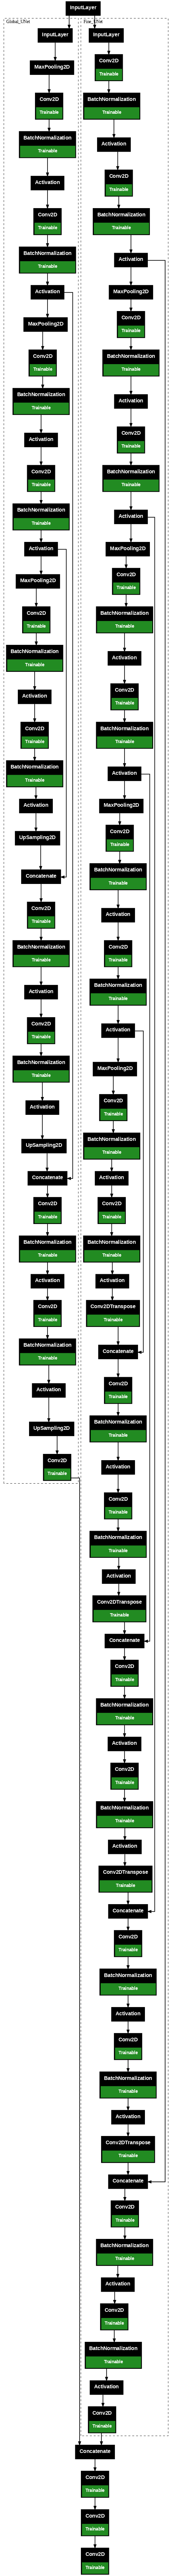

In [43]:
model = build_dual_unet(input_shape)
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)
# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

**LOSSES**

In [27]:
def dice_coeff(y_true, y_pred, smooth=10e-6, from_logits=False):
  """
  Compute Dice Loss for multi-class segmentation.

  Args:
  y_true: Ground truth labels (one-hot encoded) with shape (batch_size, height, width, num_classes).
  y_pred: Predicted logits with shape (batch_size, height, width, num_classes).
  smooth: Smoothing factor to avoid division by zero.

  Returns:
  Dice loss.
  """

  if from_logits:
    y_pred = tf.nn.softmax(y_pred)


  y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

  # Flatten the tensors
  y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
  y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

  # Compute intersection and union
  intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
  union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)

  # Compute Dice coefficient
  dice = (2. * intersection + smooth) / (union + smooth)

  # Compute Dice loss
  return 1 - tf.reduce_mean(dice)

In [28]:
def dice_loss(smooth=10e-6, from_logits=False):
  def loss(y_true, y_pred):
    return dice_coeff(y_true, y_pred, smooth, from_logits)
  return loss


**CALLBACKS**

In [29]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [30]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred[2], axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [44]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_fused_output_mean_iou',
    mode='max',
    patience=patience,
    restore_best_weights=True
)
viz_callback = VizCallback(val_img[index], val_lbl[index], frequency=5)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=patience/2, min_lr=1e-6, monitor='val_fused_output_mean_iou', mode='max')

**MODEL COMPILE - TRAINING**

In [45]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        "Fine_UNet": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        "Global_UNet": dice_loss(from_logits=True),
        "fused_output": dice_loss(),
    },
    loss_weights={
        "Fine_UNet": 0.3,
        "Global_UNet": 0.3,
        "fused_output": 0.4,
    },
    metrics={
        "Fine_UNet": [],
        "Global_UNet": [],
        "fused_output": [MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])],
    }
)

Epoch 1/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - Fine_UNet_loss: 0.2267 - Global_UNet_loss: 0.4346 - fused_output_loss: 0.2895 - fused_output_mean_iou: 0.1694 - loss: 0.9508

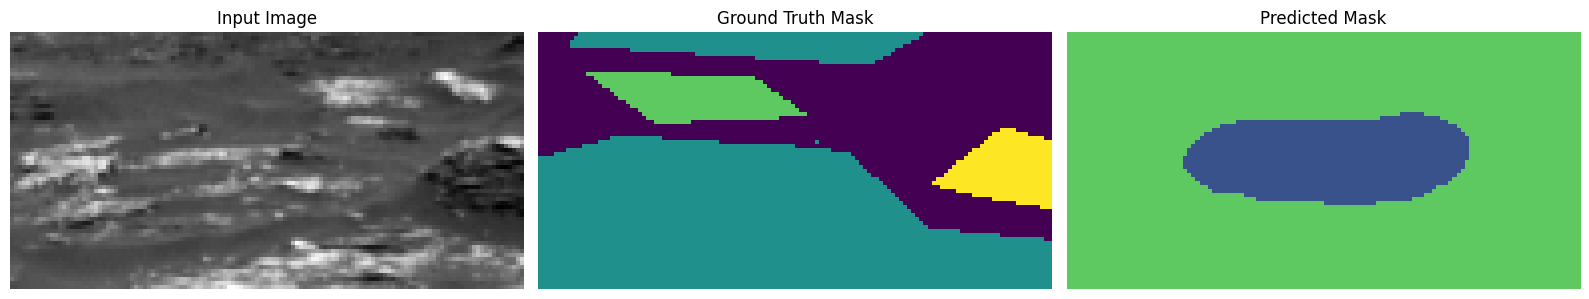

141/141 ━━━━━━━━━━━━━━━━━━━━ 63s 229ms/step - Fine_UNet_loss: 0.2266 - Global_UNet_loss: 0.4344 - fused_output_loss: 0.2894 - fused_output_mean_iou: 0.1695 - loss: 0.9505 - val_Fine_UNet_loss: 0.2665 - val_Global_UNet_loss: 0.5423 - val_fused_output_loss: 0.3576 - val_fused_output_mean_iou: 0.0967 - val_loss: 1.1663 - learning_rate: 0.0010
Epoch 2/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - Fine_UNet_loss: 0.2089 - Global_UNet_loss: 0.3612 - fused_output_loss: 0.2521 - fused_output_mean_iou: 0.2293 - loss: 0.8222 - val_Fine_UNet_loss: 0.2797 - val_Global_UNet_loss: 0.6551 - val_fused_output_loss: 0.3730 - val_fused_output_mean_iou: 0.0684 - val_loss: 1.3077 - learning_rate: 0.0010
Epoch 3/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - Fine_UNet_loss: 0.1983 - Global_UNet_loss: 0.3351 - fused_output_loss: 0.2349 - fused_output_mean_iou: 0.2686 - loss: 0.7684 - val_Fine_UNet_loss: 0.2342 - val_Global_UNet_loss: 0.6923 - val_fused_output_loss: 0.3486 - val_fused_output_mean_iou: 0.

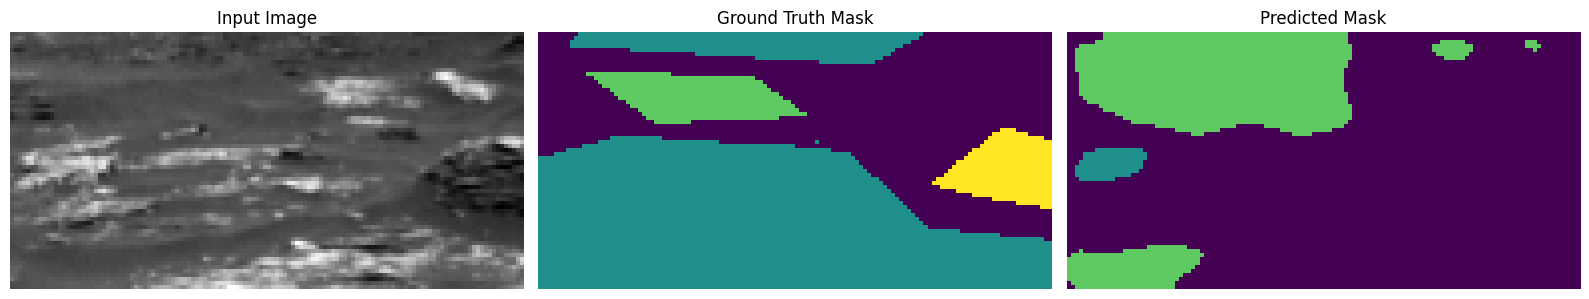

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - Fine_UNet_loss: 0.1649 - Global_UNet_loss: 0.2864 - fused_output_loss: 0.2051 - fused_output_mean_iou: 0.3448 - loss: 0.6564 - val_Fine_UNet_loss: 0.1841 - val_Global_UNet_loss: 0.3012 - val_fused_output_loss: 0.2219 - val_fused_output_mean_iou: 0.2897 - val_loss: 0.7061 - learning_rate: 0.0010
Epoch 7/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1657 - Global_UNet_loss: 0.2836 - fused_output_loss: 0.2057 - fused_output_mean_iou: 0.3416 - loss: 0.6549 - val_Fine_UNet_loss: 0.1963 - val_Global_UNet_loss: 0.3252 - val_fused_output_loss: 0.2146 - val_fused_output_mean_iou: 0.3118 - val_loss: 0.7349 - learning_rate: 0.0010
Epoch 8/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - Fine_UNet_loss: 0.1651 - Global_UNet_loss: 0.2792 - fused_output_loss: 0.2000 - fused_output_mean_iou: 0.3518 - loss: 0.6443 - val_Fine_UNet_loss: 0.2254 - val_Global_UNet_loss: 0.5614 - val_fused_output_loss: 0.2412 - val_fused_output_mean_iou: 0.1

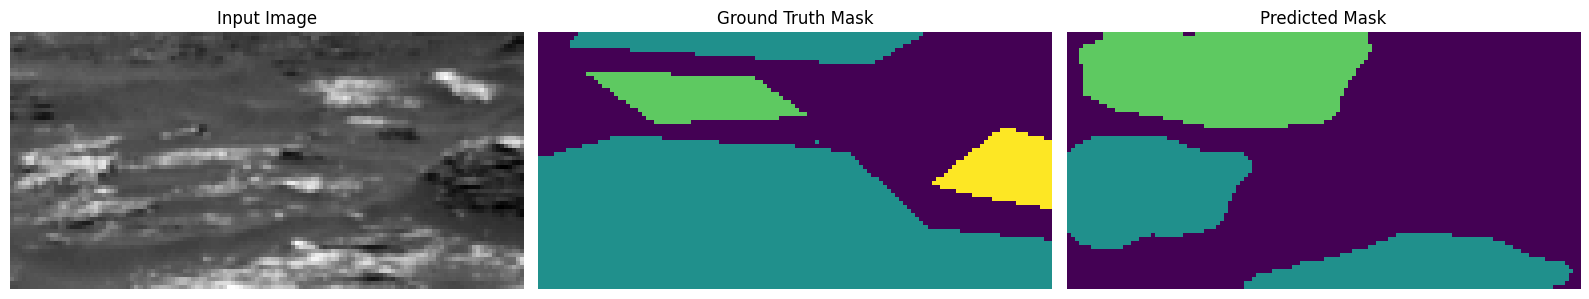

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - Fine_UNet_loss: 0.1558 - Global_UNet_loss: 0.2630 - fused_output_loss: 0.1396 - fused_output_mean_iou: 0.3577 - loss: 0.5584 - val_Fine_UNet_loss: 0.2390 - val_Global_UNet_loss: 0.2638 - val_fused_output_loss: 0.1296 - val_fused_output_mean_iou: 0.3524 - val_loss: 0.6329 - learning_rate: 0.0010
Epoch 12/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1549 - Global_UNet_loss: 0.2614 - fused_output_loss: 0.1413 - fused_output_mean_iou: 0.3678 - loss: 0.5575 - val_Fine_UNet_loss: 0.1536 - val_Global_UNet_loss: 0.3147 - val_fused_output_loss: 0.1446 - val_fused_output_mean_iou: 0.3529 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 13/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - Fine_UNet_loss: 0.1522 - Global_UNet_loss: 0.2591 - fused_output_loss: 0.1389 - fused_output_mean_iou: 0.3706 - loss: 0.5503 - val_Fine_UNet_loss: 0.1830 - val_Global_UNet_loss: 0.3182 - val_fused_output_loss: 0.1489 - val_fused_output_mean_iou: 0

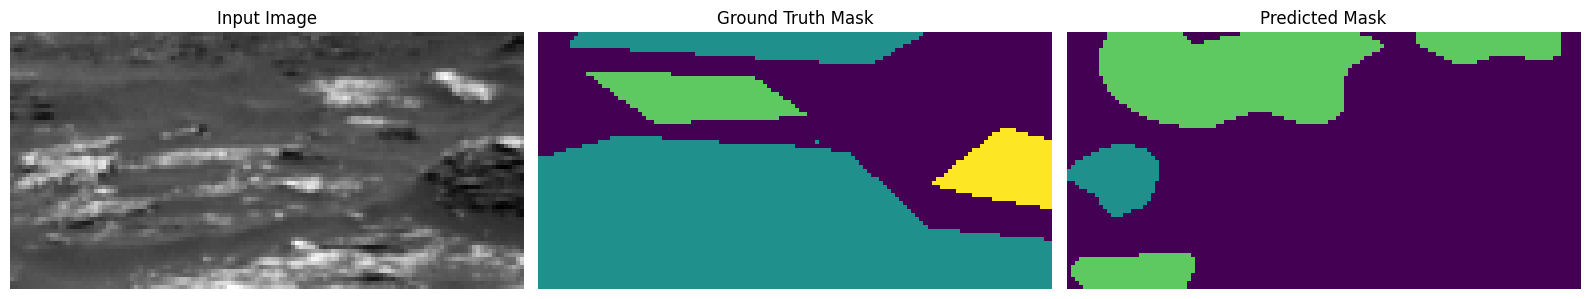

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Fine_UNet_loss: 0.1531 - Global_UNet_loss: 0.2490 - fused_output_loss: 0.1401 - fused_output_mean_iou: 0.3865 - loss: 0.5423 - val_Fine_UNet_loss: 0.1600 - val_Global_UNet_loss: 0.4909 - val_fused_output_loss: 0.2122 - val_fused_output_mean_iou: 0.1583 - val_loss: 0.8602 - learning_rate: 0.0010
Epoch 17/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1532 - Global_UNet_loss: 0.2537 - fused_output_loss: 0.1453 - fused_output_mean_iou: 0.3753 - loss: 0.5521 - val_Fine_UNet_loss: 0.1981 - val_Global_UNet_loss: 0.2376 - val_fused_output_loss: 0.1182 - val_fused_output_mean_iou: 0.3923 - val_loss: 0.5547 - learning_rate: 0.0010
Epoch 18/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1527 - Global_UNet_loss: 0.2422 - fused_output_loss: 0.1346 - fused_output_mean_iou: 0.3921 - loss: 0.5295 - val_Fine_UNet_loss: 0.1958 - val_Global_UNet_loss: 0.3190 - val_fused_output_loss: 0.1526 - val_fused_output_mean_iou: 0

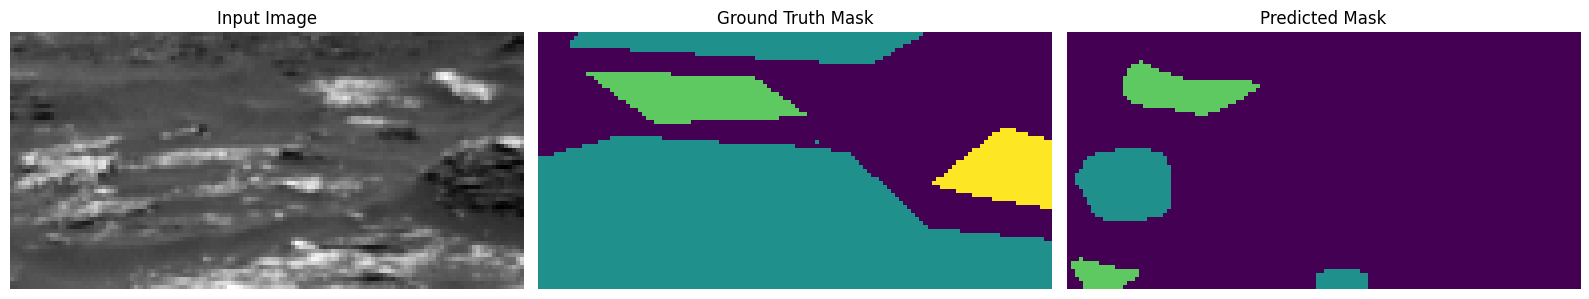

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1466 - Global_UNet_loss: 0.2326 - fused_output_loss: 0.1323 - fused_output_mean_iou: 0.4027 - loss: 0.5115 - val_Fine_UNet_loss: 0.1746 - val_Global_UNet_loss: 0.2652 - val_fused_output_loss: 0.1297 - val_fused_output_mean_iou: 0.3464 - val_loss: 0.5700 - learning_rate: 0.0010
Epoch 22/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - Fine_UNet_loss: 0.1485 - Global_UNet_loss: 0.2463 - fused_output_loss: 0.1342 - fused_output_mean_iou: 0.3934 - loss: 0.5290 - val_Fine_UNet_loss: 0.2341 - val_Global_UNet_loss: 0.3135 - val_fused_output_loss: 0.1741 - val_fused_output_mean_iou: 0.2536 - val_loss: 0.7230 - learning_rate: 0.0010
Epoch 23/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - Fine_UNet_loss: 0.1479 - Global_UNet_loss: 0.2348 - fused_output_loss: 0.1299 - fused_output_mean_iou: 0.4007 - loss: 0.5125 - val_Fine_UNet_loss: 0.2127 - val_Global_UNet_loss: 0.2241 - val_fused_output_loss: 0.1148 - val_fused_output_mean_iou: 0

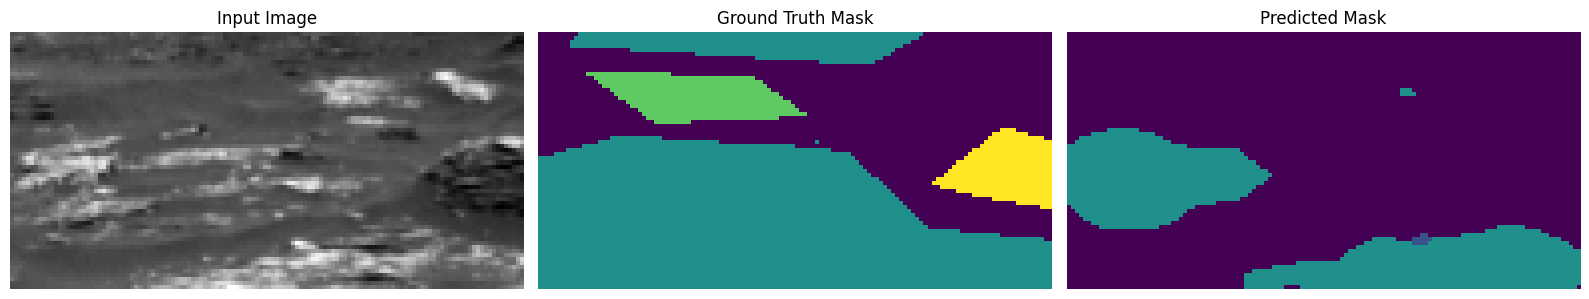

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1527 - Global_UNet_loss: 0.2493 - fused_output_loss: 0.1431 - fused_output_mean_iou: 0.3843 - loss: 0.5450 - val_Fine_UNet_loss: 0.1502 - val_Global_UNet_loss: 0.2173 - val_fused_output_loss: 0.1116 - val_fused_output_mean_iou: 0.4185 - val_loss: 0.4808 - learning_rate: 0.0010
Epoch 27/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - Fine_UNet_loss: 0.1466 - Global_UNet_loss: 0.2339 - fused_output_loss: 0.1276 - fused_output_mean_iou: 0.3996 - loss: 0.5081 - val_Fine_UNet_loss: 0.1515 - val_Global_UNet_loss: 0.2293 - val_fused_output_loss: 0.1132 - val_fused_output_mean_iou: 0.4170 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 28/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - Fine_UNet_loss: 0.1496 - Global_UNet_loss: 0.2361 - fused_output_loss: 0.1280 - fused_output_mean_iou: 0.3952 - loss: 0.5137 - val_Fine_UNet_loss: 0.1366 - val_Global_UNet_loss: 0.2246 - val_fused_output_loss: 0.1092 - val_fused_output_mean_iou: 0

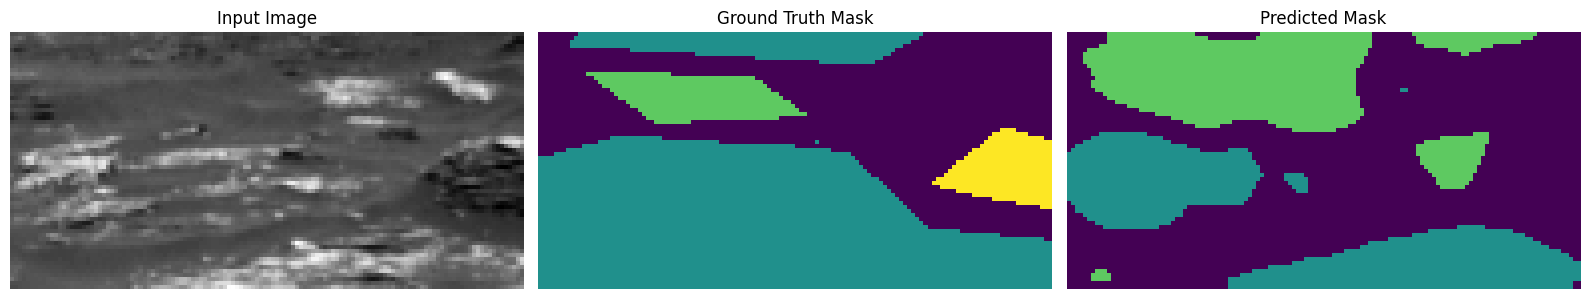

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Fine_UNet_loss: 0.1495 - Global_UNet_loss: 0.2343 - fused_output_loss: 0.1318 - fused_output_mean_iou: 0.3958 - loss: 0.5156 - val_Fine_UNet_loss: 0.1571 - val_Global_UNet_loss: 0.2130 - val_fused_output_loss: 0.1099 - val_fused_output_mean_iou: 0.4228 - val_loss: 0.4807 - learning_rate: 0.0010
Epoch 32/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1590 - Global_UNet_loss: 0.2303 - fused_output_loss: 0.1306 - fused_output_mean_iou: 0.4090 - loss: 0.5199 - val_Fine_UNet_loss: 0.1922 - val_Global_UNet_loss: 0.2211 - val_fused_output_loss: 0.1181 - val_fused_output_mean_iou: 0.3875 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 33/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - Fine_UNet_loss: 0.1463 - Global_UNet_loss: 0.2245 - fused_output_loss: 0.1312 - fused_output_mean_iou: 0.4101 - loss: 0.5019 - val_Fine_UNet_loss: 0.1469 - val_Global_UNet_loss: 0.2500 - val_fused_output_loss: 0.1219 - val_fused_output_mean_iou: 0

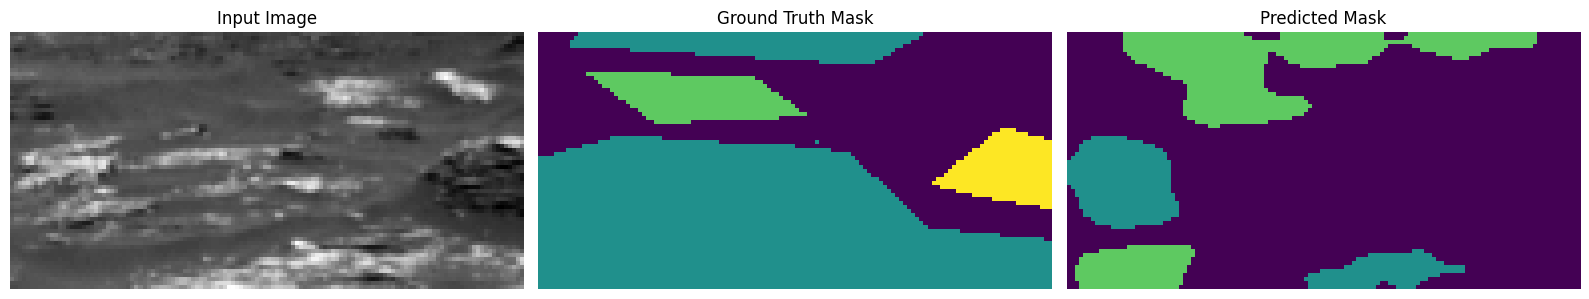

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - Fine_UNet_loss: 0.1487 - Global_UNet_loss: 0.2193 - fused_output_loss: 0.1261 - fused_output_mean_iou: 0.4213 - loss: 0.4941 - val_Fine_UNet_loss: 0.1474 - val_Global_UNet_loss: 0.2664 - val_fused_output_loss: 0.1343 - val_fused_output_mean_iou: 0.3407 - val_loss: 0.5495 - learning_rate: 0.0010
Epoch 37/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - Fine_UNet_loss: 0.1467 - Global_UNet_loss: 0.2221 - fused_output_loss: 0.1247 - fused_output_mean_iou: 0.4093 - loss: 0.4935 - val_Fine_UNet_loss: 0.1438 - val_Global_UNet_loss: 0.2110 - val_fused_output_loss: 0.1093 - val_fused_output_mean_iou: 0.4281 - val_loss: 0.4643 - learning_rate: 0.0010
Epoch 38/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1428 - Global_UNet_loss: 0.2259 - fused_output_loss: 0.1249 - fused_output_mean_iou: 0.4239 - loss: 0.4935 - val_Fine_UNet_loss: 0.1439 - val_Global_UNet_loss: 0.2067 - val_fused_output_loss: 0.1099 - val_fused_output_mean_iou: 0

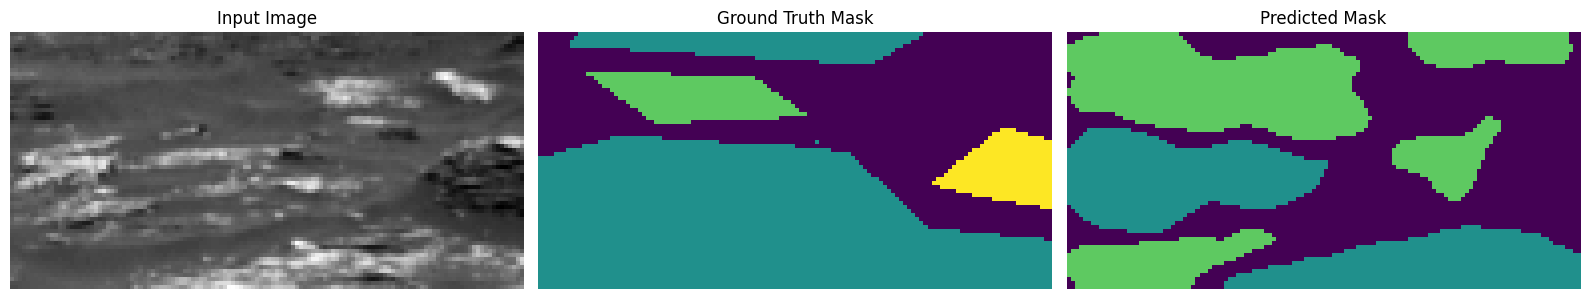

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - Fine_UNet_loss: 0.1344 - Global_UNet_loss: 0.2015 - fused_output_loss: 0.1118 - fused_output_mean_iou: 0.4399 - loss: 0.4478 - val_Fine_UNet_loss: 0.1324 - val_Global_UNet_loss: 0.1909 - val_fused_output_loss: 0.1003 - val_fused_output_mean_iou: 0.4577 - val_loss: 0.4257 - learning_rate: 5.0000e-04
Epoch 42/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - Fine_UNet_loss: 0.1341 - Global_UNet_loss: 0.1978 - fused_output_loss: 0.1119 - fused_output_mean_iou: 0.4489 - loss: 0.4438 - val_Fine_UNet_loss: 0.1412 - val_Global_UNet_loss: 0.2060 - val_fused_output_loss: 0.1095 - val_fused_output_mean_iou: 0.4165 - val_loss: 0.4581 - learning_rate: 5.0000e-04
Epoch 43/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1374 - Global_UNet_loss: 0.1995 - fused_output_loss: 0.1188 - fused_output_mean_iou: 0.4461 - loss: 0.4557 - val_Fine_UNet_loss: 0.1327 - val_Global_UNet_loss: 0.2033 - val_fused_output_loss: 0.1015 - val_fused_output_mea

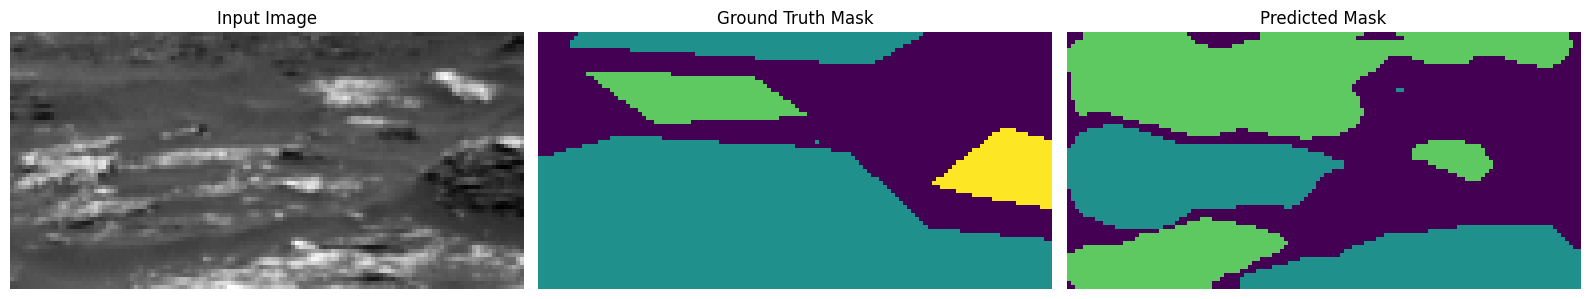

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Fine_UNet_loss: 0.1370 - Global_UNet_loss: 0.2015 - fused_output_loss: 0.1138 - fused_output_mean_iou: 0.4519 - loss: 0.4522 - val_Fine_UNet_loss: 0.1443 - val_Global_UNet_loss: 0.1968 - val_fused_output_loss: 0.1033 - val_fused_output_mean_iou: 0.4534 - val_loss: 0.4466 - learning_rate: 5.0000e-04
Epoch 47/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1380 - Global_UNet_loss: 0.1978 - fused_output_loss: 0.1151 - fused_output_mean_iou: 0.4526 - loss: 0.4509 - val_Fine_UNet_loss: 0.1307 - val_Global_UNet_loss: 0.2085 - val_fused_output_loss: 0.1090 - val_fused_output_mean_iou: 0.4179 - val_loss: 0.4504 - learning_rate: 5.0000e-04
Epoch 48/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1335 - Global_UNet_loss: 0.1903 - fused_output_loss: 0.1100 - fused_output_mean_iou: 0.4578 - loss: 0.4338 - val_Fine_UNet_loss: 0.1285 - val_Global_UNet_loss: 0.2051 - val_fused_output_loss: 0.1037 - val_fused_output_mea

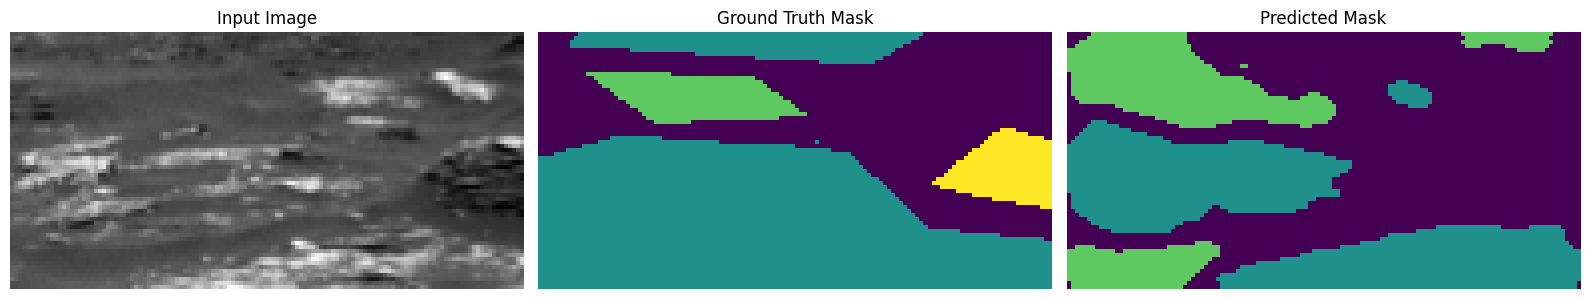

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Fine_UNet_loss: 0.1336 - Global_UNet_loss: 0.1969 - fused_output_loss: 0.1143 - fused_output_mean_iou: 0.4517 - loss: 0.4448 - val_Fine_UNet_loss: 0.1354 - val_Global_UNet_loss: 0.1994 - val_fused_output_loss: 0.0978 - val_fused_output_mean_iou: 0.4623 - val_loss: 0.4342 - learning_rate: 5.0000e-04
Epoch 52/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1332 - Global_UNet_loss: 0.1939 - fused_output_loss: 0.1120 - fused_output_mean_iou: 0.4549 - loss: 0.4391 - val_Fine_UNet_loss: 0.1382 - val_Global_UNet_loss: 0.1934 - val_fused_output_loss: 0.1041 - val_fused_output_mean_iou: 0.4337 - val_loss: 0.4373 - learning_rate: 5.0000e-04
Epoch 53/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1332 - Global_UNet_loss: 0.1887 - fused_output_loss: 0.1182 - fused_output_mean_iou: 0.4577 - loss: 0.4401 - val_Fine_UNet_loss: 0.1355 - val_Global_UNet_loss: 0.1816 - val_fused_output_loss: 0.0964 - val_fused_output_mea

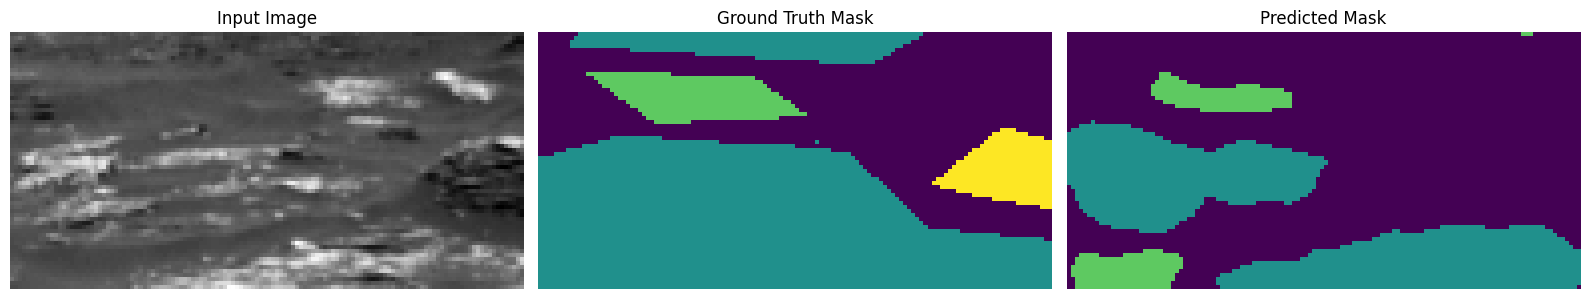

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Fine_UNet_loss: 0.1317 - Global_UNet_loss: 0.1859 - fused_output_loss: 0.1147 - fused_output_mean_iou: 0.4620 - loss: 0.4323 - val_Fine_UNet_loss: 0.1268 - val_Global_UNet_loss: 0.2114 - val_fused_output_loss: 0.1108 - val_fused_output_mean_iou: 0.4010 - val_loss: 0.4499 - learning_rate: 5.0000e-04
Epoch 57/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1331 - Global_UNet_loss: 0.1948 - fused_output_loss: 0.1076 - fused_output_mean_iou: 0.4531 - loss: 0.4355 - val_Fine_UNet_loss: 0.1276 - val_Global_UNet_loss: 0.1872 - val_fused_output_loss: 0.0963 - val_fused_output_mean_iou: 0.4557 - val_loss: 0.4134 - learning_rate: 5.0000e-04
Epoch 58/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1310 - Global_UNet_loss: 0.1845 - fused_output_loss: 0.1092 - fused_output_mean_iou: 0.4642 - loss: 0.4247 - val_Fine_UNet_loss: 0.1329 - val_Global_UNet_loss: 0.2065 - val_fused_output_loss: 0.1063 - val_fused_output_mea

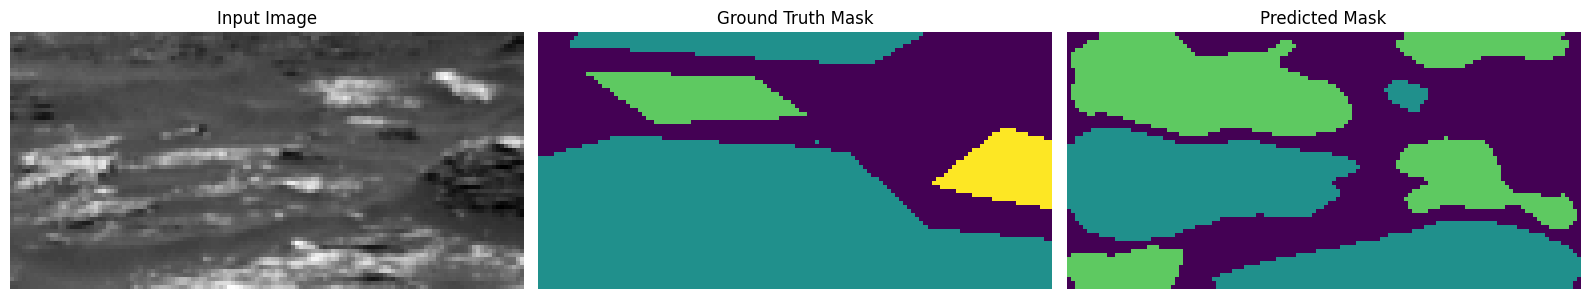

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Fine_UNet_loss: 0.1312 - Global_UNet_loss: 0.1939 - fused_output_loss: 0.1076 - fused_output_mean_iou: 0.4562 - loss: 0.4328 - val_Fine_UNet_loss: 0.1240 - val_Global_UNet_loss: 0.1981 - val_fused_output_loss: 0.0993 - val_fused_output_mean_iou: 0.4650 - val_loss: 0.4233 - learning_rate: 5.0000e-04
Epoch 62/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1343 - Global_UNet_loss: 0.1931 - fused_output_loss: 0.1123 - fused_output_mean_iou: 0.4628 - loss: 0.4397 - val_Fine_UNet_loss: 0.1265 - val_Global_UNet_loss: 0.1872 - val_fused_output_loss: 0.0947 - val_fused_output_mean_iou: 0.4665 - val_loss: 0.4086 - learning_rate: 5.0000e-04
Epoch 63/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1334 - Global_UNet_loss: 0.1916 - fused_output_loss: 0.1111 - fused_output_mean_iou: 0.4565 - loss: 0.4361 - val_Fine_UNet_loss: 0.1400 - val_Global_UNet_loss: 0.1953 - val_fused_output_loss: 0.1010 - val_fused_output_mea

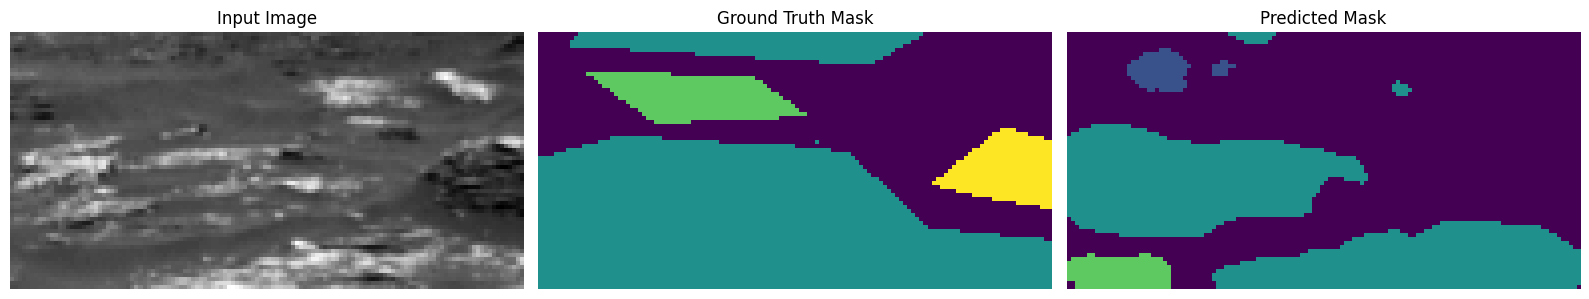

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Fine_UNet_loss: 0.1326 - Global_UNet_loss: 0.1868 - fused_output_loss: 0.1103 - fused_output_mean_iou: 0.4623 - loss: 0.4297 - val_Fine_UNet_loss: 0.1214 - val_Global_UNet_loss: 0.2027 - val_fused_output_loss: 0.0981 - val_fused_output_mean_iou: 0.4584 - val_loss: 0.4234 - learning_rate: 5.0000e-04
Epoch 67/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1304 - Global_UNet_loss: 0.1862 - fused_output_loss: 0.1029 - fused_output_mean_iou: 0.4653 - loss: 0.4195 - val_Fine_UNet_loss: 0.1648 - val_Global_UNet_loss: 0.1882 - val_fused_output_loss: 0.1028 - val_fused_output_mean_iou: 0.4256 - val_loss: 0.4578 - learning_rate: 5.0000e-04
Epoch 68/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1313 - Global_UNet_loss: 0.1807 - fused_output_loss: 0.1064 - fused_output_mean_iou: 0.4706 - loss: 0.4184 - val_Fine_UNet_loss: 0.1293 - val_Global_UNet_loss: 0.2548 - val_fused_output_loss: 0.1204 - val_fused_output_mea

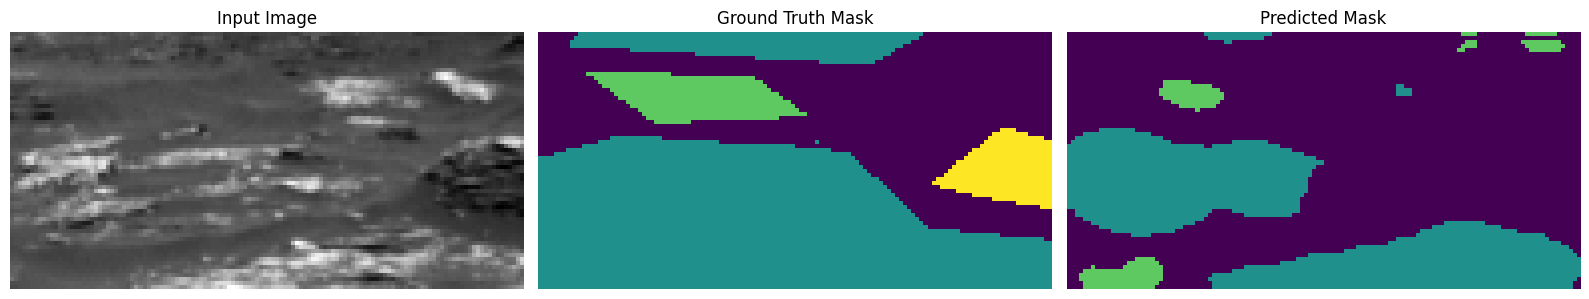

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Fine_UNet_loss: 0.1264 - Global_UNet_loss: 0.1721 - fused_output_loss: 0.1046 - fused_output_mean_iou: 0.4819 - loss: 0.4030 - val_Fine_UNet_loss: 0.1260 - val_Global_UNet_loss: 0.1887 - val_fused_output_loss: 0.0973 - val_fused_output_mean_iou: 0.4558 - val_loss: 0.4123 - learning_rate: 2.5000e-04
Epoch 72/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1283 - Global_UNet_loss: 0.1736 - fused_output_loss: 0.1023 - fused_output_mean_iou: 0.4759 - loss: 0.4042 - val_Fine_UNet_loss: 0.1244 - val_Global_UNet_loss: 0.1855 - val_fused_output_loss: 0.0983 - val_fused_output_mean_iou: 0.4523 - val_loss: 0.4098 - learning_rate: 2.5000e-04
Epoch 73/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1304 - Global_UNet_loss: 0.1753 - fused_output_loss: 0.1131 - fused_output_mean_iou: 0.4731 - loss: 0.4188 - val_Fine_UNet_loss: 0.1233 - val_Global_UNet_loss: 0.1933 - val_fused_output_loss: 0.0979 - val_fused_output_mea

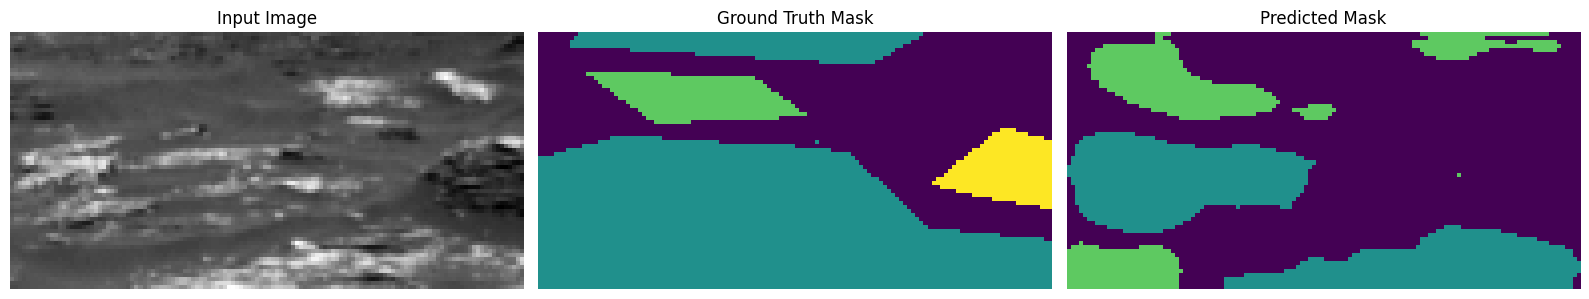

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - Fine_UNet_loss: 0.1274 - Global_UNet_loss: 0.1767 - fused_output_loss: 0.1097 - fused_output_mean_iou: 0.4733 - loss: 0.4138 - val_Fine_UNet_loss: 0.1232 - val_Global_UNet_loss: 0.1888 - val_fused_output_loss: 0.0981 - val_fused_output_mean_iou: 0.4533 - val_loss: 0.4114 - learning_rate: 2.5000e-04
Epoch 77/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1278 - Global_UNet_loss: 0.1737 - fused_output_loss: 0.1038 - fused_output_mean_iou: 0.4729 - loss: 0.4053 - val_Fine_UNet_loss: 0.1289 - val_Global_UNet_loss: 0.1877 - val_fused_output_loss: 0.0986 - val_fused_output_mean_iou: 0.4423 - val_loss: 0.4166 - learning_rate: 2.5000e-04
Epoch 78/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Fine_UNet_loss: 0.1265 - Global_UNet_loss: 0.1738 - fused_output_loss: 0.1024 - fused_output_mean_iou: 0.4823 - loss: 0.4028 - val_Fine_UNet_loss: 0.1268 - val_Global_UNet_loss: 0.1949 - val_fused_output_loss: 0.0977 - val_fused_output_mea

In [46]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, lr_callback],
    verbose=1
).history

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'DualUNet.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

**MODEL INFERENCE**

In [47]:
model_filename = 'DualUNet.keras'

In [53]:
# Load UNet model without compiling
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)


In [54]:
# Evaluate the model on the test set and print the results
preds = model.predict(val_img, verbose=0, batch_size=10)
preds = np.argmax(preds[2], axis=-1)
print(f"Predictions shape: {preds.shape}")
del model

Predictions shape: (250, 64, 128)


In [55]:
def per_class_iou(y_true, y_pred, num_classes=5):
    y_true = tf.cast(y_true, tf.int32)

    ious = []
    for i in range(num_classes):
        y_true_class = tf.cast(tf.equal(y_true, i), tf.float32)
        y_pred_class = tf.cast(tf.equal(y_pred, i), tf.float32)

        intersection = tf.reduce_sum(y_true_class * y_pred_class)
        union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class) - intersection

        iou = tf.math.divide_no_nan(intersection, union)
        ious.append(iou)

    return ious

In [56]:
ious = per_class_iou(val_lbl, preds)

In [57]:
for idx, iou in enumerate(np.array(ious)):
  print('class '+ str(idx) + ' has an IOU of ' + str(iou) + "\n")

class 0 has an IOU of 0.3851725

class 1 has an IOU of 0.7142617

class 2 has an IOU of 0.621681

class 3 has an IOU of 0.706832

class 4 has an IOU of 0.0



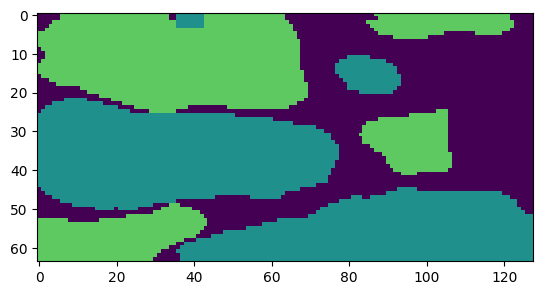

In [58]:
colormap = create_segmentation_colormap(num_classes)
plt.imshow(apply_colormap(preds[index], colormap))